
# OLS sklearn — Time‑based Validation (Migration Panel)

This notebook implements a **Linear Regression (OLS)** using `sklearn` on your migration panel:
- Rebuilds features (including interactions and canton dummies)
- **Time-based train/test split** (80/20 by year)
- Evaluates **MSE** and **R²** on the test period
- Optional: **TimeSeriesSplit** cross-validation for robustness


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

# === CONFIG ===
DATA_PATH = Path("/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics/data/databasecsv.csv")

def load_data(path=DATA_PATH):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path.resolve()}")
        
    df = pd.read_csv(path, sep=";")
    df.columns = df.columns.str.strip()
    return df
def prepare_dataframe(df: pd.DataFrame):

    # Encode canton
    df["canton_id"] = df["canton"].astype("category").cat.codes
    df["migration_lag1"] = df.groupby("canton_id")["migration_rate"].shift(1)

    base_vars = [
        "log_rent_avg",
        "log_avg_income",
        "log_unemployment",
        "log_schockexposure",
        "CLUSTER1",
        "CLUSTER2",
        "migration_lag1",
    ]

    required_before_interactions = [
        "migration_rate", "canton", "year",
        "log_rent_avg", "log_avg_income",
        "log_unemployment", "log_schockexposure",
        "CLUSTER1", "CLUSTER2"
    ]

    missing = [c for c in required_before_interactions if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns before interactions: {missing}")

    # === INTERACTIONS ===
    df["log_avg_income_x_log_rent_avg"] = df["log_avg_income"] * df["log_rent_avg"]
    df["log_unemployment_rate_x_log_avg_income"] = df["log_unemployment"] * df["log_avg_income"]
    df["log_schockexposure_x_CLUSTER1"] = df["log_schockexposure"] * df["CLUSTER1"]
    df["log_schockexposure_x_CLUSTER2"] = df["log_schockexposure"] * df["CLUSTER2"]

    interaction_vars = [
        "log_avg_income_x_log_rent_avg",
        "log_unemployment_rate_x_log_avg_income",
        "log_schockexposure_x_CLUSTER1",
        "log_schockexposure_x_CLUSTER2",
    ]

    required_cols = ["migration_rate", "canton", "year"] + base_vars + interaction_vars

    missing_after = [c for c in required_cols if c not in df.columns]
    if missing_after:
        raise KeyError(f"Missing required columns after interactions: {missing_after}")

    df_model = df.dropna(subset=required_cols).copy()
    print(f"After initial cleaning: {len(df_model)} rows")

    # Canton dummies
    df_model = pd.get_dummies(df_model, columns=["canton"], drop_first=True)

    df_model["year"] = pd.to_numeric(df_model["year"], errors="coerce")

    # Final feature list
    feature_cols = base_vars + interaction_vars + [c for c in df_model.columns if c.startswith("canton_")]

    # Numeric conversion
    X_df = df_model[feature_cols].apply(pd.to_numeric, errors="coerce")
    y_ser = pd.to_numeric(df_model["migration_rate"], errors="coerce")

    mask_valid = (~X_df.isna().any(axis=1)) & (~y_ser.isna()) & (~df_model["year"].isna())
    before = len(df_model)
    X_df = X_df.loc[mask_valid]
    y_ser = y_ser.loc[mask_valid]
    df_model = df_model.loc[mask_valid].copy()
    after = len(df_model)

    print(f"Rows kept after numeric coercion: {after} (dropped {before-after})")

    return df_model, X_df, y_ser, feature_cols
    
def time_split(df: pd.DataFrame, feature_cols):

    df_sorted = df.sort_values(["year"]).reset_index(drop=True)
    years = df_sorted["year"].unique()
    cut = int(0.8 * len(years)) if len(years) > 1 else 1

    train_years = set(years[:cut])
    test_years = set(years[cut:]) if cut < len(years) else set()

    X_train = df_sorted.loc[df_sorted["year"].isin(train_years), feature_cols].to_numpy()
    y_train = df_sorted.loc[df_sorted["year"].isin(train_years), "migration_rate"].to_numpy()
    X_test  = df_sorted.loc[df_sorted["year"].isin(test_years),  feature_cols].to_numpy()
    y_test  = df_sorted.loc[df_sorted["year"].isin(test_years),  "migration_rate"].to_numpy()

    print("Split shapes ->",
          "X_train", X_train.shape, "X_test", X_test.shape,
          "y_train", y_train.shape, "y_test", y_test.shape)

    return X_train, X_test, y_train, y_test
def run_ols(X_train, y_train, X_test, y_test):

    model = LinearRegression()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    coefs = model.coef_
    intercept = model.intercept_

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return model, y_pred, mse, r2, coefs, intercept
# 1. LOAD
df = load_data()
print("Loaded dataset:", df.shape)

# 2. PREPARE
df_model, X_df, y_ser, feature_cols = prepare_dataframe(df)

# 3. SPLIT
X_train, X_test, y_train, y_test = time_split(df_model, feature_cols)

# 4. OLS
model, y_pred, mse, r2, coefs, intercept = run_ols(X_train, y_train, X_test, y_test)

# 5. RESULTS
print("\n=== Sklearn OLS (LinearRegression) ===")
print(f"MSE: {mse:.4f}")
print(f"R^2:  {r2:.4f}")

print("\n=== FIRST 5 PREDICTIONS ===")
for yp, yt in list(zip(y_pred[:5], y_test[:5])):
    print(f"pred={yp:.3f} | true={yt:.3f}")

print("\n=== OLS COEFFICIENTS ===")
for name, coef in zip(feature_cols, coefs):
    print(f"{name:40s}  {coef:.6f}")

print(f"\nIntercept: {intercept:.6f}")


Loaded dataset: (285, 38)
After initial cleaning: 234 rows
Rows kept after numeric coercion: 234 (dropped 0)
Split shapes -> X_train (182, 37) X_test (52, 37) y_train (182,) y_test (52,)

=== Sklearn OLS (LinearRegression) ===
MSE: 0.1304
R^2:  -0.2393

=== FIRST 5 PREDICTIONS ===
pred=-0.120 | true=-0.180
pred=-0.034 | true=0.110
pred=0.437 | true=0.580
pred=0.287 | true=0.530
pred=-0.119 | true=0.040

=== OLS COEFFICIENTS ===
log_rent_avg                              54.530857
log_avg_income                            31.105357
log_unemployment                          -4.792211
log_schockexposure                        -0.039290
CLUSTER1                                  0.412940
CLUSTER2                                  -0.249364
migration_lag1                            0.025937
log_avg_income_x_log_rent_avg             -4.666785
log_unemployment_rate_x_log_avg_income    0.441792
log_schockexposure_x_CLUSTER1             1.889764
log_schockexposure_x_CLUSTER2             0.350766
c

ROOT added to sys.path: /Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics
After initial cleaning: 234 rows
Rows kept after numeric coercion: 234 (dropped 0)
Split shapes -> X_train (182, 37) X_test (52, 37) y_train (182,) y_test (52,)
OK, données prêtes pour le plot.


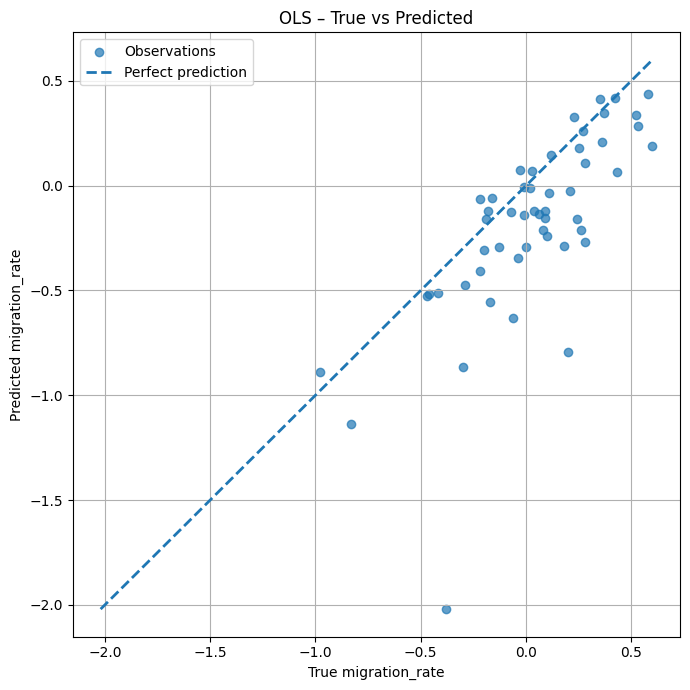

In [7]:
from pathlib import Path
import sys
import pandas as pd

# 1. Ajouter le projet au path
ROOT = Path("/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics")
sys.path.append(str(ROOT))

print("ROOT added to sys.path:", ROOT)

# 2. Importer ton code OLS
from src.ML.ols.ols import load_data, prepare_dataframe, time_split, run_ols
# si ton fichier ne s'appelle pas ols_sklearn.py, dis-le-moi et j’adapte la ligne

# 3. Charger les données
df = load_data()

# 4. Préparer les données
df_model, X_df, y_ser, feature_cols = prepare_dataframe(df)

# 5. Découpe temporelle
X_train, X_test, y_train, y_test = time_split(df_model, feature_cols)

# 6. OLS
model, y_pred, mse, r2, coefs, intercept = run_ols(X_train, y_train, X_test, y_test)

print("OK, données prêtes pour le plot.")

from src.ML.ols.plotols import plot_true_vs_pred_ols

plot_true_vs_pred_ols(y_test, y_pred)
